Evolução de casos de COVID-19 no Brasil
====================

Baseado nos dados oficiais divulgados pelo governo federal.

TODO:

- [ ] 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.optimize
import pandas as pd
import nmmn.misc, nmmn.stats
import matplotlib.dates as mdates
import tqdm

# 1. Dados

## Casos confirmados e suspeitos

In [3]:
import astropy.io.ascii as ascii

Mude a linha abaixo para a localização do arquivo de dados. Se você baixou o código do repositório no github, o argumento do comando deve ser 

    'corona-brasil.dat'

In [4]:
data = ascii.read('/Users/nemmen/Dropbox/science/playground/data/corona-brasil.dat')

In [5]:
data

t,casos-confirmados,suspeitas,mortes
str9,int64,float64,int64
2020-2-6,0,9.0,0
2020-3-5,8,636.0,0
2020-3-9,25,930.0,0
2020-3-10,34,893.0,0
2020-3-11,52,907.0,0
2020-3-12,77,1427.0,0
2020-3-13,98,1485.0,0
2020-3-14,121,1494.0,0
2020-3-15,200,1915.0,0


In [6]:
t=data['t']
n=data['casos-confirmados']
nerr=data['suspeitas']
mortes=data['mortes']

Converte tempo para formato pandas

In [7]:
tp=pd.to_datetime(t)

In [8]:
df = pd.DataFrame(data={'n':n,'susp':nerr, 'mortes':mortes}, index=tp)

## Inspeção dos dados

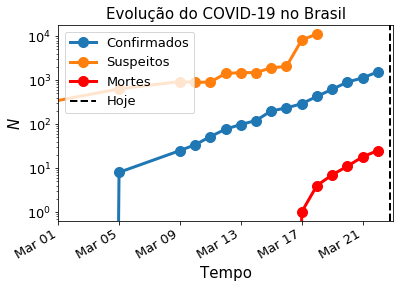

In [9]:
ax=df['n'].plot(linewidth=3,style='o-',ms=10, label='Confirmados')
df['susp'].plot(linewidth=3,style='o-',ms=10, label='Suspeitos')
df['mortes'].plot(linewidth=3,style='o-r',ms=10, label='Mortes')
ax.axvline(pd.to_datetime('today'), color='k', linestyle='--', lw=2, label='Hoje')

ylabel('$N$',size=15)
xlabel('Tempo', size=15)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
legend(fontsize=13)
yscale('log')
title('Evolução do COVID-19 no Brasil', fontsize=15)
ax.set_xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-03-23'))
tick_params(axis='both', which='major', labelsize=13)
tick_params(axis='both', which='minor', labelsize=12)

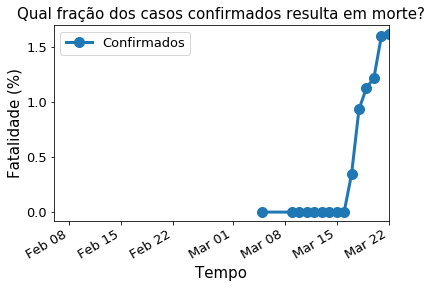

In [10]:
ratio=df['mortes']/df['n']*100
ax=ratio.plot(linewidth=3,style='o-',ms=10, label='Confirmados')

ylabel('Fatalidade (%)',size=15)
xlabel('Tempo', size=15)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
legend(fontsize=13)
title('Qual fração dos casos confirmados resulta em morte?', fontsize=15)
tick_params(axis='both', which='major', labelsize=13)
tick_params(axis='both', which='minor', labelsize=12)

## Capacidade do sistema hospitalar

Insira aqui os dados sobre a capacidade do sistema hospitalar.

Fontes dos números abaixo:

- https://www1.folha.uol.com.br/equilibrioesaude/2020/03/so-internacoes-em-utis-podem-custar-mais-de-r-1-bi-ao-sus-diz-estudo.shtml

In [11]:
# quantidade de respiradores SUS no pais
respSUS=5846

# quantidade de respiradores total, incluindo sistema privado
resp=64900

# 2. Definição dos modelos

quantos dias usar para ajustar a exponencial? i.e. dias antes do último dado publicado

In [12]:
nlim=5

## Capacidade do sistema hospitalar

fracao de casualidades: qual porcentagem dos casos confirmados resulta em morte? [Dados da WHO](https://www.theguardian.com/world/2020/mar/22/what-is-coronavirus-and-what-is-the-mortality-rate)

In [13]:
razaoMortes=0.034

Fracao da população do Brasil em SP

In [14]:
fracSP=0.22

Estimativa de respiradores no sistema SUS no estado de São Paulo. Normalizado pela fração da população que mora no estado de SP

In [15]:
respSP=fracSP*respSUS

## Funções a serem ajustadas aos dados

Exponencial em escala linear: $$N = a e^{t/b}$$ onde 
- $t$ é o tempo
- $b$ é o tempo que os casos demoram para dobrar

In [16]:
fexp=lambda x,a,b: a*exp(x/b)

Exponencial em escala logarítmica: $$y=(a + t/b)/\ln(10)$$ onde $y= \log_{10} N$.

Esta forma da função é mais apropriada para ajustes em escala log.

In [17]:
fexplog=lambda x,a,b: (a + x/b)/log(10.)

# 3. Ajustes

Conversão das datas formato `pandas` para um array normal, para fins de ajuste de modelos. Eu subtrai 2020 abaixo para não ter problemas com o ajuste dos modelos

In [18]:
t=nmmn.misc.date2dec(df.index)
tfit=t-2020

Arrays maiores de tempos para graficar modelo

In [19]:
t2=linspace(tfit[0],tfit[-1]+0.008)

In [20]:
t3=linspace(tfit[0],tfit[-1]+0.08)

## 3.1. Todos os dados

Perceba nos gráficos abaixo que fazer um ajuste usando todos os dados não reproduz bem os últimos dados da série. i.e. os pontos estão um pouco acima da curva. O "e-folding time" da exponencial está mudando.

fix n=0 values, which will give errors when taking the log

In [21]:
nfix=n.astype(float)
nfix[n<1]=0.001

In [22]:
p0=1.,0.1 # initial guess for the parameters

Ajuste

In [23]:
#fit,cov = scipy.optimize.curve_fit(fexp, xfit, n, p0=p0)
fitAll,covAll = scipy.optimize.curve_fit(fexplog, tfit, log10(nfix), p0=p0)

Tempo para dobrar o número de casos em dias

In [24]:
fitAll[1]*365

3.1490962080033844

### Escala linear

(737485.0, 737507.0)

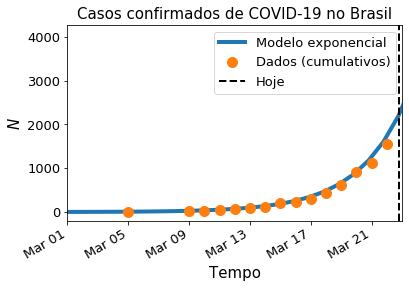

In [25]:
ax=pd.Series(10**fexplog(t2,fitAll[0],fitAll[1]),index=nmmn.misc.convertyear(t2+2020)).plot(label='Modelo exponencial', lw=4)
#ax=pd.Series(fexp(x2,fit[0],fit[1]),index=nmmn.misc.convertyear(x2+2020)).plot(label='Modelo exponencial', lw=4)
df['n'].plot(label='Dados (cumulativos)',linewidth=3,style='o',ms=10)
ax.axvline(pd.to_datetime('today'), color='k', linestyle='--', lw=2, label='Hoje')

xlabel('Tempo', fontsize=15)
ylabel('$N$', fontsize=15)
title('Casos confirmados de COVID-19 no Brasil', fontsize=15)

legend(fontsize=13)
tick_params(axis='both', which='major', labelsize=13)
tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-03-23'))

### Escala log

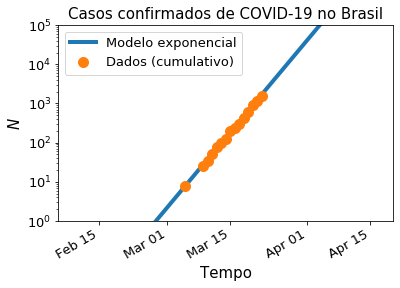

In [26]:
ax=pd.Series(10**fexplog(t3,fitAll[0],fitAll[1]),index=nmmn.misc.convertyear(t3+2020)).plot(label='Modelo exponencial', lw=4)
#ax=pd.Series(fexp(t3,fit1[0],fit1[1]),index=nmmn.misc.convertyear(x2+2020)).plot(label='Modelo exponencial', lw=4)
df['n'].plot(label='Dados (cumulativo)',linewidth=3,style='o',ms=10)

# capacidade sistema hospitalar
#pd.Series(respSP*ones_like(x2),index=nmmn.misc.convertyear(x2+2020)).plot(label='Capacidade respiradores SP', lw=4)

xlabel('Tempo', fontsize=15)
ylabel('$N$', fontsize=15)
title('Casos confirmados de COVID-19 no Brasil', fontsize=15)
ylim(1,100000)

legend(fontsize=13)
tick_params(axis='both', which='major', labelsize=13)
tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
yscale('log')

## 3.2. Somente últimos dias 

seleciona somente os últimos dias

In [27]:
tlast=tfit[tfit.size-nlim:]
nlast=n[n.size-nlim:]

Ajuste

In [28]:
fitLast,covLast = scipy.optimize.curve_fit(fexplog, tlast, log10(nlast), p0=p0)

Tempo para dobrar o número de casos em dias

In [29]:
fitLast[1]*365

3.150450738934144

### Escala linear

In [30]:
t0='2020-03-17'
t1='2020-03-25'

(737501.0, 737509.0)

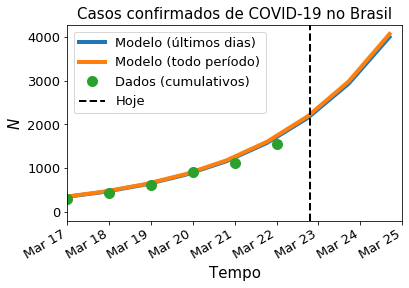

In [31]:
ax=pd.Series(10**fexplog(t2,fitLast[0],fitLast[1]),index=nmmn.misc.convertyear(t2+2020)).plot(label='Modelo (últimos dias)', lw=4)
pd.Series(10**fexplog(t2,fitAll[0],fitAll[1]),index=nmmn.misc.convertyear(t2+2020)).plot(label='Modelo (todo período)', lw=4)
df['n'].plot(label='Dados (cumulativos)',linewidth=3,style='o',ms=10)
ax.axvline(pd.to_datetime('today'), color='k', linestyle='--', lw=2, label='Hoje')

xlabel('Tempo', fontsize=15)
ylabel('$N$', fontsize=15)
title('Casos confirmados de COVID-19 no Brasil', fontsize=15)

legend(fontsize=13)
tick_params(axis='both', which='major', labelsize=13)
tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_xlim(pd.Timestamp(t0), pd.Timestamp(t1))

### Escala log

(737501.0, 737509.0)

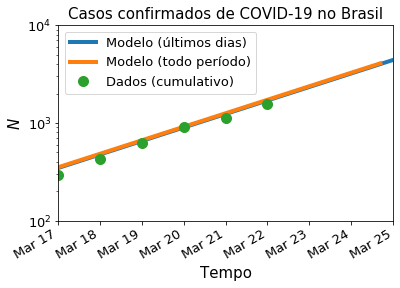

In [32]:
ax=pd.Series(10**fexplog(t3,fitLast[0],fitLast[1]),index=nmmn.misc.convertyear(t3+2020)).plot(label='Modelo (últimos dias)', lw=4)
pd.Series(10**fexplog(t2,fitAll[0],fitAll[1]),index=nmmn.misc.convertyear(t2+2020)).plot(label='Modelo (todo período)', lw=4)
df['n'].plot(label='Dados (cumulativo)',linewidth=3,style='o',ms=10)

xlabel('Tempo', fontsize=15)
ylabel('$N$', fontsize=15)
title('Casos confirmados de COVID-19 no Brasil', fontsize=15)
ylim(100,10000)

legend(fontsize=13)
tick_params(axis='both', which='major', labelsize=13)
tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
yscale('log')
ax.set_xlim(pd.Timestamp(t0), pd.Timestamp(t1))

# Projeções (futuro)

Quantos casos críticos—que necessitarão de internação—acontecerão nos próximos dias?

seleciona somente os últimos dias

In [37]:
tDeathLast=tfit[n.size-nlim:]
nDeathLast=mortes[n.size-nlim:]

Ajuste

In [38]:
fitDeath,covDeath = scipy.optimize.curve_fit(fexplog, tDeathLast, log10(nDeathLast), p0=p0)

Tempo para dobrar o número de mortes em dias

In [39]:
fitDeath[1]*365

2.1634468332428582

Ambas as linhas tracejada e pontilhada consistem de extrapolações, que tentam prever o número de casos críticos, baseadas em exponenciais. Não há física nestes modelos—eles são puramente fenomenológicos. 

A linha vermelha tracejada assume que o número de casos críticos será semelhante ao número de mortes. A linha azul pontilhada assume que o número de casos críticos corresponde a 3.4% do número de casos suspeitos; ou seja, a mesma fração de mortes medida na China. 

As setas vermelhas indicam as datas nas quais se prevê saturação do sistema público de saúde (SUS) devido ao excesso de casos críticos de COVID-19. Se isto acontecer, os hospitais não terão mais capacidade de tratar todos os doentes e terão que escolher quem será tratado.

(737500.0, 737521.0)

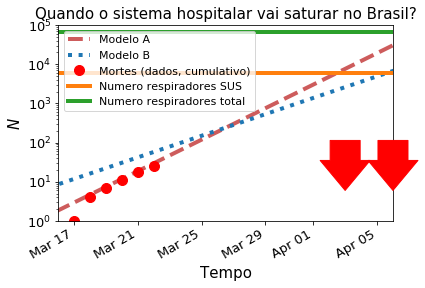

In [54]:
ax=pd.Series(10**fexplog(t3,fitDeath[0],fitDeath[1]),index=nmmn.misc.convertyear(t3+2020)).plot(label='Modelo A', lw=4, style='--', color='IndianRed')
pd.Series(razaoMortes*10**fexplog(t3,fitLast[0],fitLast[1]),index=nmmn.misc.convertyear(t3+2020)).plot(label='Modelo B', lw=4, style=':')
df['mortes'].plot(label='Mortes (dados, cumulativo)',linewidth=3,style='or',ms=10)

# capacidade sistema hospitalar
pd.Series(respSUS*ones_like(t3),index=nmmn.misc.convertyear(t3+2020)).plot(label='Numero respiradores SUS', lw=4)
pd.Series(resp*ones_like(t3),index=nmmn.misc.convertyear(t3+2020)).plot(label='Numero respiradores total', lw=4)

xarr=[pd.Timestamp('2020-04-3'),pd.Timestamp('2020-04-6')]
for x in xarr:
    annotate('', (x, 6), xytext=(0, 50), textcoords='offset points', arrowprops=dict(headwidth=50,width=30,headlength=30,color='red'))

xlabel('Tempo', fontsize=15)
ylabel('$N$', fontsize=15)
title('Quando o sistema hospitalar vai saturar no Brasil?', fontsize=15)
ylim(1,100000)

legend(fontsize=11,loc='upper left')
tick_params(axis='both', which='major', labelsize=13)
tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
yscale('log')
ax.set_xlim(pd.Timestamp('2020-03-16'), pd.Timestamp('2020-04-06'))

## Conclusão

De acordo com os modelos *data-driven* acima:

---
**ATENÇÃO**

há a possibilidade de o sistema SUS saturar sua capacidade de respiradores entre os dias 3 e 6 de Abril, devido ao grande número de casos críticos de COVID-19

---

Notas:

- Os modelos puramente exponenciais ajustados aos dados foram extrapolados duas semanas no futuro, o que é uma extrapolação considerável. 
- Dado o grande número de variáveis envolvidas que afetam a propagação do COVID-19, *é bastante difícil saber como o número de casos críticos vai evoluir depois de dez dias*

# Sandbox (playing around)

In [ ]:
mortesSP=fracSP*df['mortes']

In [ ]:
ax=pd.Series(razaoMortes*fracSP*10**fexplog(x2,fitLast[0],fitLast[1]),index=nmmn.misc.convertyear(x2+2020)).plot(label='Casos críticos (modelo)', lw=4)
mortesSP.plot(label='Mortes (dados, cumulativo)',linewidth=3,style='o',ms=10)
ax.axvline(pd.to_datetime('today'), color='k', linestyle='--', lw=2, label='Hoje')

# capacidade sistema hospitalar
pd.Series(respSP*ones_like(x2),index=nmmn.misc.convertyear(x2+2020)).plot(label='Numero respiradores SUS', lw=4, color='r')

xlabel('Tempo', fontsize=15)
ylabel('$N$', fontsize=15)
title('Quando o sistema hospitalar vai saturar em SP?', fontsize=15)
ylim(1,100000)

legend(fontsize=13)
tick_params(axis='both', which='major', labelsize=13)
tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
yscale('log')

## Monte Carlo

- [ ] generate data below the upper limits
- [ ] fits
- [ ] plot confidence band of fits

In [ ]:
# How many correlations will be tested?
nsim=500

In [ ]:
# Array which will store the resulting distribution of r-values
ysim=np.zeros_like(xfit)

In [ ]:
# fix n=0 values
nreal=n.astype(float)
nreal[n<1]=0.01

In [ ]:
ax=pd.Series(fexp(x2,fit[0],fit[1]),index=nmmn.misc.convertyear(x2+2020)).plot(lw=4)
df['n'].plot(label='Dados (cumulativos)',linewidth=3,style='o',ms=10)

for i in tqdm.tqdm(range(nsim)):
    # Generates mock values
    for j in range(x.size):
        ysim[j]=np.random.uniform(log10(nreal[j]),log10(nerr[j]))

    # fits model  
    #fit,cov = scipy.optimize.curve_fit(fexp, xfit, ysim, p0=p0)
    fit2,cov = scipy.optimize.curve_fit(fexplog, xfit, ysim, p0=p0)

    # plot
    pd.Series(10**fexplog(x2,fit2[0],fit2[1]),index=nmmn.misc.convertyear(x2+2020)).plot(alpha=0.01, color='k')

ax.axvline(pd.to_datetime('today'), color='k', linestyle='--', lw=2, label='Hoje')
xlabel('Tempo', fontsize=15)
ylabel('$N$', fontsize=15)
title('Casos de COVID-19 no Brasil', fontsize=15)

#legend(fontsize=13)
tick_params(axis='both', which='major', labelsize=13)
tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
yscale('log')
ylim(1,5e4)
ax.set_xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-03-25'))

In [ ]:
ax=pd.Series(razaoMortes*fexp(x2,fit[0],fit[1]),index=nmmn.misc.convertyear(x2+2020)).plot(lw=4)
df['mortes'].plot(label='Dados (cumulativos)',linewidth=3,style='o',ms=10)

for i in tqdm.tqdm(range(nsim)):
    # Generates mock values
    for j in range(x.size):
        ysim[j]=np.random.uniform(log10(nreal[j]),log10(nerr[j]))

    # fits model  
    #fit,cov = scipy.optimize.curve_fit(fexp, xfit, ysim, p0=p0)
    fit2,cov = scipy.optimize.curve_fit(fexplog, xfit, ysim, p0=p0)

    # plot
    pd.Series(razaoMortes*10**fexplog(x2,fit2[0],fit2[1]),index=nmmn.misc.convertyear(x2+2020)).plot(alpha=0.01, color='k')

ax.axvline(pd.to_datetime('today'), color='k', linestyle='--', lw=2, label='Hoje')
xlabel('Tempo', fontsize=15)
ylabel('$N$', fontsize=15)
title('Mortes por COVID-19 no Brasil', fontsize=15)

#legend(fontsize=13)
tick_params(axis='both', which='major', labelsize=13)
tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
yscale('log')
ylim(1,5e4)
ax.set_xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-03-25'))

In [ ]:
    # fix n=0 values
    nreal=n.astype(float)
    nreal[n<1]=0.01

    # Generates mock values
    for j in range(x.size):
        ysim[j]=np.random.uniform(log10(nreal[j]),log10(nerr[j]))

    # fits model  
    fit2,cov = scipy.optimize.curve_fit(fexplog, xfit, ysim, p0=p0)

    # plot
    pd.Series(fexplog(x2,fit2[0],fit2[1]),index=nmmn.misc.convertyear(x2+2020)).plot(lw=4)
    pd.Series(ysim,index=nmmn.misc.convertyear(xfit+2020)).plot(style='o',ms=10)